In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
seed = 42
tf.random.set_seed(seed)

In [3]:
data = pd.read_csv('..\\Data\\ze41_mol_desc_db_red.csv', header=0, sep=';', decimal=',')

In [4]:
col_names = data.columns
x_cols = ['P_VSA_MR_5', 'Mor04m', 'E1p', 'Mor22s', 'LUMO / eV']
X = data[x_cols].astype('float32')
y = data[col_names[1:3]].astype('float32')

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=seed)
X_train = pd.DataFrame(X_train)
X_train.columns = X.columns

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(X_train)

MinMaxScaler()

In [7]:
X_train_s = scaler.transform(X_train)
X_valid_s = scaler.transform(X_valid)

In [8]:
class Autoencoder(keras.models.Model):
    def __init__(self, latent_dim=2):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
            keras.layers.Dense(latent_dim, activation='linear'),
            keras.layers.LeakyReLU(),
        ])
        self.decoder = tf.keras.Sequential([
            keras.layers.Dense(len(x_cols), activation='linear')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
autoencoder = Autoencoder(latent_dim=2)

In [10]:
autoencoder.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    loss='mean_squared_error')

In [11]:
autoencoder.fit(X_train_s, X_train_s, validation_split=0.1, epochs=100)

Epoch 1/100
2/2 [==============================] - 0s 35ms/step - loss: 0.2069 - val_loss: 0.0774
Epoch 2/100
2/2 [==============================] - 0s 8ms/step - loss: 0.1217 - val_loss: 0.0593
Epoch 3/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0877 - val_loss: 0.0578
Epoch 4/100
2/2 [==============================] - 0s 0s/step - loss: 0.0680 - val_loss: 0.0684
Epoch 5/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0617 - val_loss: 0.0795
Epoch 6/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0630 - val_loss: 0.0827
Epoch 7/100
2/2 [==============================] - 0s 0s/step - loss: 0.0616 - val_loss: 0.0788
Epoch 8/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0577 - val_loss: 0.0721
Epoch 9/100
2/2 [==============================] - 0s 0s/step - loss: 0.0526 - val_loss: 0.0641
Epoch 10/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0491 - val_loss: 0.0564
Epoch 11/100
2/2 [=============

2/2 [==============================] - 0s 0s/step - loss: 0.0197 - val_loss: 0.0132
Epoch 86/100
2/2 [==============================] - 0s 0s/step - loss: 0.0196 - val_loss: 0.0139
Epoch 87/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0194 - val_loss: 0.0155
Epoch 88/100
2/2 [==============================] - 0s 0s/step - loss: 0.0196 - val_loss: 0.0157
Epoch 89/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0195 - val_loss: 0.0143
Epoch 90/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0194 - val_loss: 0.0128
Epoch 91/100
2/2 [==============================] - 0s 0s/step - loss: 0.0195 - val_loss: 0.0124
Epoch 92/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0192 - val_loss: 0.0133
Epoch 93/100
2/2 [==============================] - 0s 0s/step - loss: 0.0193 - val_loss: 0.0144
Epoch 94/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0196 - val_loss: 0.0140
Epoch 95/100
2/2 [====================

In [12]:
X_train_enc = autoencoder.encoder(X_train_s).numpy()

In [13]:
X_valid_enc = autoencoder.encoder(X_valid_s).numpy()

In [14]:
y_train.head()

,inhibition efficiency ZE41 / %,LinIE ZE41
33,59.0,0.954
48,54.0,0.939
12,-67.0,0.588
57,-194.0,0.220
46,-146.0,0.359


In [15]:
df_train = pd.DataFrame(X_train_enc, index=X_train.index)

In [16]:
df_valid = pd.DataFrame(X_valid_enc, index=X_valid.index)

In [17]:
df_train.columns=['dim 0', 'dim 1']
df_valid.columns=df_train.columns

In [18]:
df_train['target'] = y_train['inhibition efficiency ZE41 / %']
df_train['type'] = 0

In [19]:
df_valid['target'] = y_valid['inhibition efficiency ZE41 / %']
df_valid['type'] = 1

In [20]:
df = pd.concat([df_train, df_valid], ignore_index=False, sort=False)
df.head()

,dim 0,dim 1,target,type
33,0.344354,0.284599,59.0,0
48,0.171665,0.209718,54.0,0
12,0.911115,0.376899,-67.0,0
57,0.568869,0.885882,-194.0,0
46,0.567442,0.643048,-146.0,0


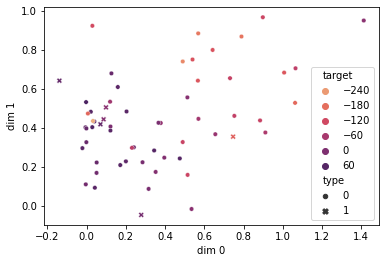

In [21]:
fig, ax = plt.subplots()
sns.scatterplot(data=df, x='dim 0', y='dim 1', hue='target', ax=ax, size='type',
               sizes={0:20, 1:30}, palette='flare', style='type')
plt.show()